# Homework - Week 5:
```
Put the "Homework5" folder inside the main "Python_DA" training folder, the path of this folder will be the base path now.
Do the following cleaning/filtering/translating tasks on ALL the source files within the "Input" folder's subfolders:

Tasks:
1. Use your "Read_parameters.ipynb" external program to read the parameter tables from "Parameters_Homework5.xlsx" (-> paramlist)
2. As the "Size" data in the 1st parameter table can be numeric and text values mixed, convert "Size" column to STRING data type (otherwise only the texts will be matched, e.g. "XL")
3. The input folder paths of the input files are in the 1st parameter table, loop through the rows of this table to do the following subtasks on each input file (put comments in the program for each subtasks to explain them to the user):
    a. Filter the parameter dataframes to input file (paramlist -> paramlist_filt)
    b. Read the input file from its input folder path
    c. Use the "Clean_order_data.ipynb" external program to clean it
    d. Filter it on only the rows with the Sizes and Countries specified for the input file
    e. Look up the related Class Names of the class id's ("H", "M", "L"), into a separate "Class Name" column
    f. Remove "Class" column, as we only need "Class ID" column instead
    g. Translate the column headers based on the last parameter table with dictionary
    h. The output folder should be a "2011" / "2012" / "2013" / "2014" subfolder inside the "Output" folder (based on input file’s name), the program should create these folders (if they do not exist)
    i. Use your "Export_to_csv.ipynb" external program to export the cleaned, filtered, translated dataframe to the output folder, the output file's name should be the same as the input file, but with a "_cleaned_filtered_translated.csv" ending
4. Read the "Orders_2011_cleaned_filtered_translated.csv" into a dataframe
    a. Create a Pivot Table on it, Rows: "Size", Columns: "Class Name", Values: "Revenue", and write it out in cell output
    b. Create a Stacked column (vertical bar) Chart on the Pivot table, and write it out
5. Create minimum three Markdown cells which give explanations about the goals of the program’s sections
6. At the end, write out the runtime, and a beep sound and a final printed message should notify the user

Upload your final Jupyter notebook (.ipynb) in ZIP!
```

In [1]:
# imports of python modules and notebooks
import os
import pandas as pd

# instead of calling the notebooks inline, most notebooks have exported functions
# import those here
%run Read_csv.ipynb
%run Read_parameters.ipynb
%run Export_to_csv.ipynb
%run Utils.ipynb
%run Clean_order_data.ipynb

## Constants, please adjust them according to your settings

In [2]:
# constants
BASE_PATH = r'd:\Trainings\Cubix\Python_DA'
HOMEWORK_DIR = 'Homework5'
INPUT_DIR = 'Input'
OUTPUT_DIR = 'Output'
PARAM_FILE = 'Parameters_Homework5.xlsx'
param_columndict = {'files':'A:B', 'sizes': 'D:E', 'countries': 'G:H', 'classes': 'J:K', 'translations': 'M:O'}

In [3]:
FULL_HOMEWORK_PATH = [BASE_PATH, HOMEWORK_DIR]
FULL_INPUT_PATH = FULL_HOMEWORK_PATH + [INPUT_DIR]

## Read parameters and prepare them for usage
```
1. Use your "Read_parameters.ipynb" external program to read the parameter tables from "Parameters_Homework5.xlsx" (-> paramlist)
2. As the "Size" data in the 1st parameter table can be numeric and text values mixed, convert "Size" column to STRING data type (otherwise only the texts will be matched, e.g. "XL")
```

In [4]:
param_pathlist = FULL_HOMEWORK_PATH + [PARAM_FILE]
parameters = read_params(param_pathlist, param_columndict, 'Parameter tables')
parameters['sizes']['Size'] = parameters['sizes']['Size'].astype('str')

## Process CSV files
```
3. The input folder paths of the input files are in the 1st parameter table, loop through the rows of this table to do the following subtasks on each input file (put comments in the program for each subtasks to explain them to the user):
```

In [5]:
def process_csv(input_name: str, input_full_path: str, output_full_path: str, params: list[pd.DataFrame]) -> None:
    """Processes a given csv file according to the specification.
    Takes 4 parameters, a file name, and the full path of the input and output.
    The last parameter is the parameters list (of DataFrames) for the filtering.
    File name is necessary, because filters are based on that.
    Returns None, its output is written to the file.
    """
    # a. Filter the parameter dataframes to input file (paramlist -> paramlist_filt)
    filtered_size_list = get_filtered_list(params['sizes'], 'Input file', input_name, 'Size')
    filtered_country_list = get_filtered_list(params['countries'], 'Input file', input_name, 'Country')
    from_column_name = get_filtered_list(params['translations'], 'Input file', input_name, 'Old header')
    to_column_name = get_filtered_list(params['translations'], 'Input file', input_name, 'New header')
    # b. Read the input file from its input folder path
    df = read_csv(input_full_path)
    # c. Use the "Clean_order_data.ipynb" external program to clean it
    df = clean_dataframe(df)
    # d. Filter it on only the rows with the Sizes and Countries specified for the input file
    df = df[ df['Size'].isin(filtered_size_list) ]
    df = df[ df['Country'].isin(filtered_country_list) ]
    # e. Look up the related Class Names of the class id's ("H", "M", "L"), into a separate "Class Name" column
    df = pd.merge(df, params['classes'], left_on='Class', right_on='Class ID', how='left')
    # f. Remove "Class" column, as we only need "Class ID" column instead
    del df['Class']
    # g. Translate the column headers based on the last parameter table with dictionary
    translate_dict = dict(zip(from_column_name, to_column_name))
    df.columns = pd.Series(df.columns).replace(translate_dict)
    # i. Use your "Export_to_csv.ipynb" external program to export the cleaned, filtered, translated dataframe
    # to the output folder, the output file's name should be the same as the input file, but with a "_cleaned_filtered_translated.csv" ending
    write_csv(df, output_full_path)

In [6]:
for row_index, file_row in parameters['files'].iterrows():
    file_name = file_row['Input file']
    file_path = file_row['Input folder path']
    file_year = get_year(file_name)
    assert file_year
    full_file_path = os.path.join(file_path, file_name)
    file_output_dir = os.path.join(BASE_PATH, HOMEWORK_DIR, OUTPUT_DIR, file_year)
    file_output_name = file_name.replace('.csv', "_cleaned_filtered_translated.csv")
    file_output_path = os.path.join(file_output_dir, file_output_name)
    # h. The output folder should be a "2011" / "2012" / "2013" / "2014" subfolder inside the "Output" folder
    # (based on input file’s name), the program should create these folders (if they do not exist)
    mkdir_minus_p(file_output_dir)
    process_csv(file_name, full_file_path, file_output_path, parameters)

## Pivot table, graph
```
4. Read the "Orders_2011_cleaned_filtered_translated.csv" into a dataframe
    a. Create a Pivot Table on it, Rows: "Size", Columns: "Class Name", Values: "Revenue", and write it out in cell output
    b. Create a Stacked column (vertical bar) Chart on the Pivot table, and write it out
```

In [7]:
file_name = "Orders_2011_cleaned_filtered_translated.csv"
year_name = get_year(file_name)
df = read_csv(BASE_PATH, HOMEWORK_DIR, OUTPUT_DIR, year_name, file_name)
pivot_sum_rev = pd.pivot_table(df, values = 'Revenue', index = ['Size'], columns = ['Class Name'], aggfunc = 'sum')
pivot_sum_rev

Class Name,High,Low,Medium
Size,,,
38,553658.0894,NaN,NaN
42,418212.1710,NaN,NaN
44,776355.9407,98618.5134,50738.052
46,14451.8980,NaN,NaN


<Axes: xlabel='Size'>

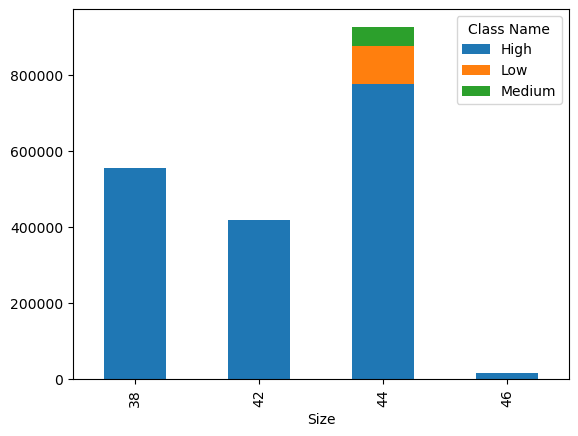

In [8]:
pivot_sum_rev.plot(kind = 'bar', stacked = True)

## Processing finished, notify the user
```
6. At the end, write out the runtime, and a beep sound and a final printed message should notify the user
```

In [9]:
runtime()

'Runtime: 00:00:02.87'

In [10]:
notify_done()

Everything done.
